In [ ]:
!nvidia-smi

Thu Aug 10 05:42:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/Highway_mumbai.mp4"

## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **23.01.2023** with version **YOLOv8.0.17**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

In [ ]:
# Pip install method (recommended)

%pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.156 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [ ]:
%pip install ultralytics --upgrade

## Install ByteTrack

[ByteTrack](https://github.com/ifzhang/ByteTrack) is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with [YOLOv8](https://github.com/ultralytics/ultralytics).

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
%pip install -q cython_bbox
%pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
%pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [ ]:
%pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [ ]:
!unzip /content/weights.zip

Archive:  /content/weights.zip
   creating: runs/detect/train/weights/
  inflating: runs/detect/train/weights/best.pt  
  inflating: runs/detect/train/weights/last.pt  


In [ ]:
# settings
MODEL = "runs/detect/train/weights/best.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11126358 parameters, 0 gradients


In [ ]:
%cd {HOME}
!yolo task-detect mode=predict model=yolov8x.pt conf=0.25 source={SOURCE_VIDEO_PATH}

/content
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 363, in entrypoint
    check_dict_alignment(full_args_dict, {a: ''})
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 184, in check_dict_alignment
    raise SyntaxError(string + CLI_HELP_MSG) from e
SyntaxError: 'task-detect' is not a valid YOLO argument. Similar arguments are i.e. ['detect'].

    Arguments received: ['yolo', 'task-detect', 'mode=predict', 'model=yolov8x.pt', 'conf=0.25', 'source=/content/Highway_mumbai.mp4']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of ('detect', 'segment', 'classify', 'pose')
                MODE (required) is one of ('train', 'val', 'predict', 'export', 'track', 'benchmark')
                ARGS (optional) are any number of custom 'ar

## Predict and annotate single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [0,1,2,3,5,7,8]


0: 480x800 20 vehicles, 206.3ms
Speed: 19.9ms preprocess, 206.3ms inference, 26.8ms postprocess per image at shape (1, 3, 480, 800)


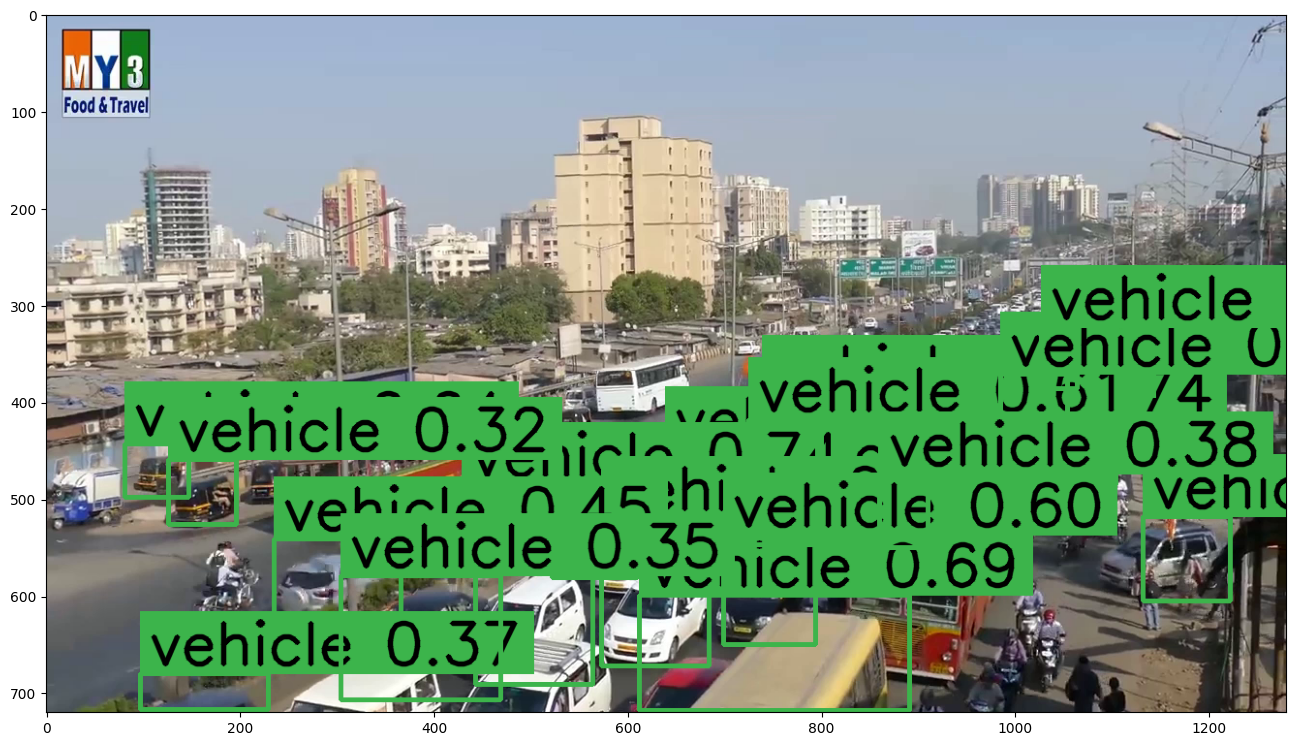

In [ ]:
import cv2
import pickle

object_count = 0

# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

object_count += len(detections)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

specific_label_detected = any("emergency" in label for label in labels)

with open("out.txt", "w") as txt_file:
    txt_file.write(f"{'T' if specific_label_detected else 'F'}{len(detections)}\n")

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [ ]:
SOURCE_VIDEO_PATH1 = f"{HOME}/test_vid.mp4"

In [ ]:
%cd {HOME}
!yolo task-detect mode=predict model=yolov8x.pt conf=0.25 source={SOURCE_VIDEO_PATH1}

/content
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 363, in entrypoint
    check_dict_alignment(full_args_dict, {a: ''})
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 184, in check_dict_alignment
    raise SyntaxError(string + CLI_HELP_MSG) from e
SyntaxError: 'task-detect' is not a valid YOLO argument. Similar arguments are i.e. ['detect'].

    Arguments received: ['yolo', 'task-detect', 'mode=predict', 'model=yolov8x.pt', 'conf=0.25', 'source=/content/test_vid.mp4']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of ('detect', 'segment', 'classify', 'pose')
                MODE (required) is one of ('train', 'val', 'predict', 'export', 'track', 'benchmark')
                ARGS (optional) are any number of custom 'arg=valu

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [0,1,2,3,5,7,8]


0: 480x800 1 emergency, 25 vehicles, 15.5ms
Speed: 4.1ms preprocess, 15.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)


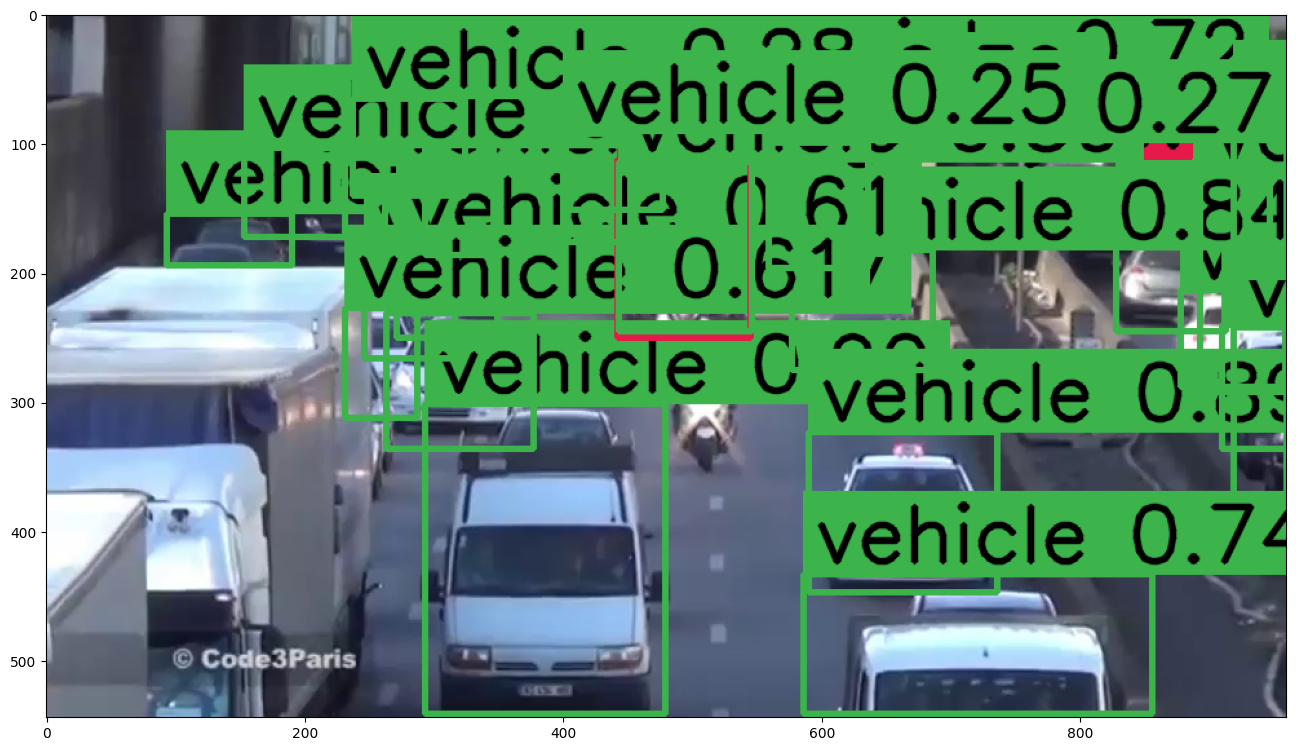

In [ ]:
import cv2
import pickle

object_count = 0

# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH1)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

object_count += len(detections)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

specific_label_detected = any("emergency" in label for label in labels)

with open("out.txt", "a") as txt_file:
    txt_file.write(f"{'T' if specific_label_detected else 'F'}{len(detections)}\n")

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [ ]:
f = open("out.txt", "r")

no_of_vehicles = []
no_of_vehicles.append(int(f.readline()[1:]))
no_of_vehicles.append(int(f.readline()[1:]))

baseTimer = 120
timeLimits = [0, 30]

print("Input no of vehicles:", *no_of_vehicles)

green_lane = "Lane 1" if f.readline()[0:] == 'T' else "Lane 2"
red_lane = "Lane 2" if green_lane == "Lane 1" else "Lane 1"


f.seek(0)
lines = f.readlines()

if (lines[0][0]=="T") or (lines[1][0]=="T"):
  if (lines[0][0]=="T"):
    lane1_time = (no_of_vehicles[0] / sum(no_of_vehicles)) * baseTimer
    lane2_time = 0
  else:
    lane1_time = 0
    lane2_time = (no_of_vehicles[1] / sum(no_of_vehicles)) * baseTimer
else:
  # Calculate lane times
  lane1_time = (no_of_vehicles[0] / sum(no_of_vehicles)) * baseTimer
  lane2_time = (no_of_vehicles[1] / sum(no_of_vehicles)) * baseTimer

  # Check for significant difference in the number of vehicles
  significant_difference = abs(no_of_vehicles[0] - no_of_vehicles[1]) > 20  # Adjust the threshold as needed

  # Decide which lane to be green and which to be red
  if significant_difference:
      if no_of_vehicles[0] > no_of_vehicles[1]:
          green_lane = "Lane 2"
          red_lane = "Lane 1"
          lane1_time = 0  # Set time for red lane to 0
      else:
          green_lane = "Lane 1"
          red_lane = "Lane 2"
          lane2_time = 0  # Set time for red lane to 0
  else:  # No significant difference, follow previous logic
      if lane1_time > lane2_time:
          green_lane = "Lane 1"
          red_lane = "Lane 2"
          lane2_time = 0  # Set time for red lane to 0
      elif lane1_time < lane2_time:
          green_lane = "Lane 2"
          red_lane = "Lane 1"
          lane1_time = 0  # Set time for red lane to 0
      else:  # Equal number of vehicles
          # Check the order in which lanes were detected
          if no_of_vehicles[0] == no_of_vehicles[1]:
              green_lane = "Lane 1"
              red_lane = "Lane 2"
          else:
              green_lane = "Lane 2"
              red_lane = "Lane 1"

# Ensure one lane is green, and adjust lane times if they exceed time limits
if lane1_time > timeLimits[1]:
    lane1_time = timeLimits[1]
    lane2_time = timeLimits[0]
elif lane2_time > timeLimits[1]:
    lane2_time = timeLimits[1]
    lane1_time = timeLimits[0]

t = [lane1_time, lane2_time]
print("Green Lane:", green_lane)
print("Red Lane:", red_lane)
print("Signal timings:", t, "Total:", sum(t))


Input no of vehicles: 20 26
Green Lane: Lane 2
Red Lane: Lane 1
Signal timings: [0, 30] Total: 30


In [ ]:
#!pip install pyserial
import serial

# Configure the serial connection
ser = serial.Serial('COM5', 9600)  # Change 'COM5' to the appropriate serial port on your system
lane1_time = 0
lane2_time = 30
data = f"{lane1_time},{lane2_time}\n"  # Format the data
# data = "hihi"
ser.write(data.encode())  # Send the data to the Arduino
print("data sent")
ser.close()  # Close the serial connection after sending the data


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.